# Picnic Hackathon 🥇✅💯
 **When great customer support meets data**


## Why the challenge?
One of our core beliefs is to offer our customers the best support possible, by allowing them, for example, to send in pictures of defect products they wish to be reimbursed for. But processing these pictures is very time-consuming as it is all done manually.

## What is the challenge?
The challenge we propose is the following: As a first step in helping customer support, come up with a way of labeling every picture that comes in according to the product that is in the picture. To keep with the Picnic spirit, we encourage to be as innovative and creative with your solutions as possible.

## Dataset
To that end, we offer the following [dataset](https://github.com/Younes-Charfaoui/Picnic-Hackathon/blob/master/images/picnic_logo.png) of pictures of defect items.

## Setting & Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from keras.models import Sequential
from keras.layers import Dropout,Conv2D, MaxPooling2D, Activation, Dense, Flatten
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
import glob
import os
import cv2

Using TensorFlow backend.


In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path_to_folder = 'gdrive/My Drive/Dataset/The Picnic Hackathon 2019/'

In [0]:
df = pd.read_csv(path_to_folder + "train.tsv",  sep='\t')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


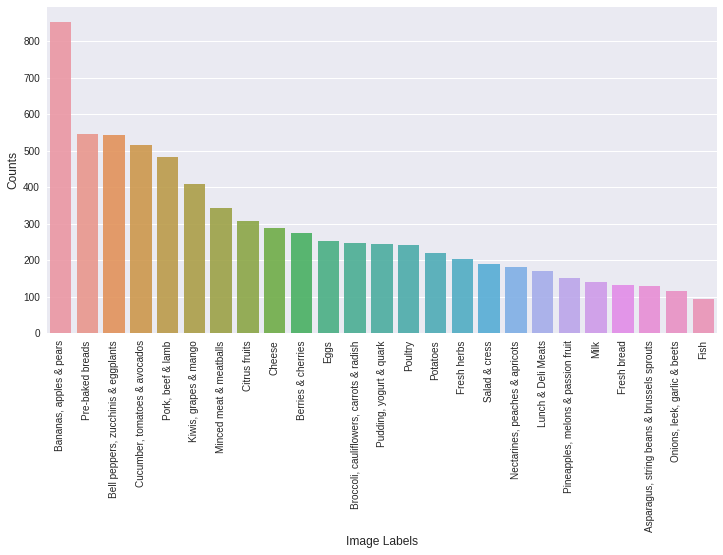

In [6]:
# getting the count of each class
label_counts = df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [0]:
"""datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.01,
                             zoom_range=[0.9, 1.25],
                             horizontal_flip= True,
                             vertical_flip= True,
                             fill_mode='reflect',
                             data_format='channels_last',
                             brightness_range=[0.5, 1.5],
                             validation_split = 0.2)"""
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split = 0.3)

In [0]:
test = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = datagen.flow_from_dataframe(dataframe=df, directory= "gdrive/My Drive/train/", 
                                              x_col= "file", y_col= "label", 
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32,
                                              subset = 'training')

valid_generator = datagen.flow_from_dataframe(dataframe=df, directory= "gdrive/My Drive/train/", 
                                              x_col= "file", y_col= "label", 
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32,
                                              subset = 'validation')

Found 5080 images belonging to 25 classes.
Found 2177 images belonging to 25 classes.


In [0]:
step_epochs = train_generator.n // train_generator.batch_size

step_validation = valid_generator.n // valid_generator.batch_size

In [0]:
test_generator = datagen.flow_from_directory(directory= path_to_folder +  "test/",
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32)

Found 0 images belonging to 0 classes.


In [0]:
labels = train_generator.class_indices
labels = {v: k for k, v in labels.items()}

In [11]:
print(labels)

{0: 'Asparagus, string beans & brussels sprouts', 1: 'Bananas, apples & pears', 2: 'Bell peppers, zucchinis & eggplants', 3: 'Berries & cherries', 4: 'Broccoli, cauliflowers, carrots & radish', 5: 'Cheese', 6: 'Citrus fruits', 7: 'Cucumber, tomatoes & avocados', 8: 'Eggs', 9: 'Fish', 10: 'Fresh bread', 11: 'Fresh herbs', 12: 'Kiwis, grapes & mango', 13: 'Lunch & Deli Meats', 14: 'Milk', 15: 'Minced meat & meatballs', 16: 'Nectarines, peaches & apricots', 17: 'Onions, leek, garlic & beets', 18: 'Pineapples, melons & passion fruit', 19: 'Pork, beef & lamb', 20: 'Potatoes', 21: 'Poultry', 22: 'Pre-baked breads', 23: 'Pudding, yogurt & quark', 24: 'Salad & cress'}


In [0]:
"""X_list, y_list = [], []
size = train_generator.n//train_generator.batch_size
print(size)
for i in range(train_generator.n//train_generator.batch_size):
  print(i)
  X, y = train_generator.next()
  X_list.append(X)
  y_list.append(y)"""
  

In [0]:
# X_test, y_test = valid_generator.next()

In [0]:
"""from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, = train_test_split(X, y, shuffle = True, test_size = 0.3)"""

In [12]:
X, y = train_generator.next()

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


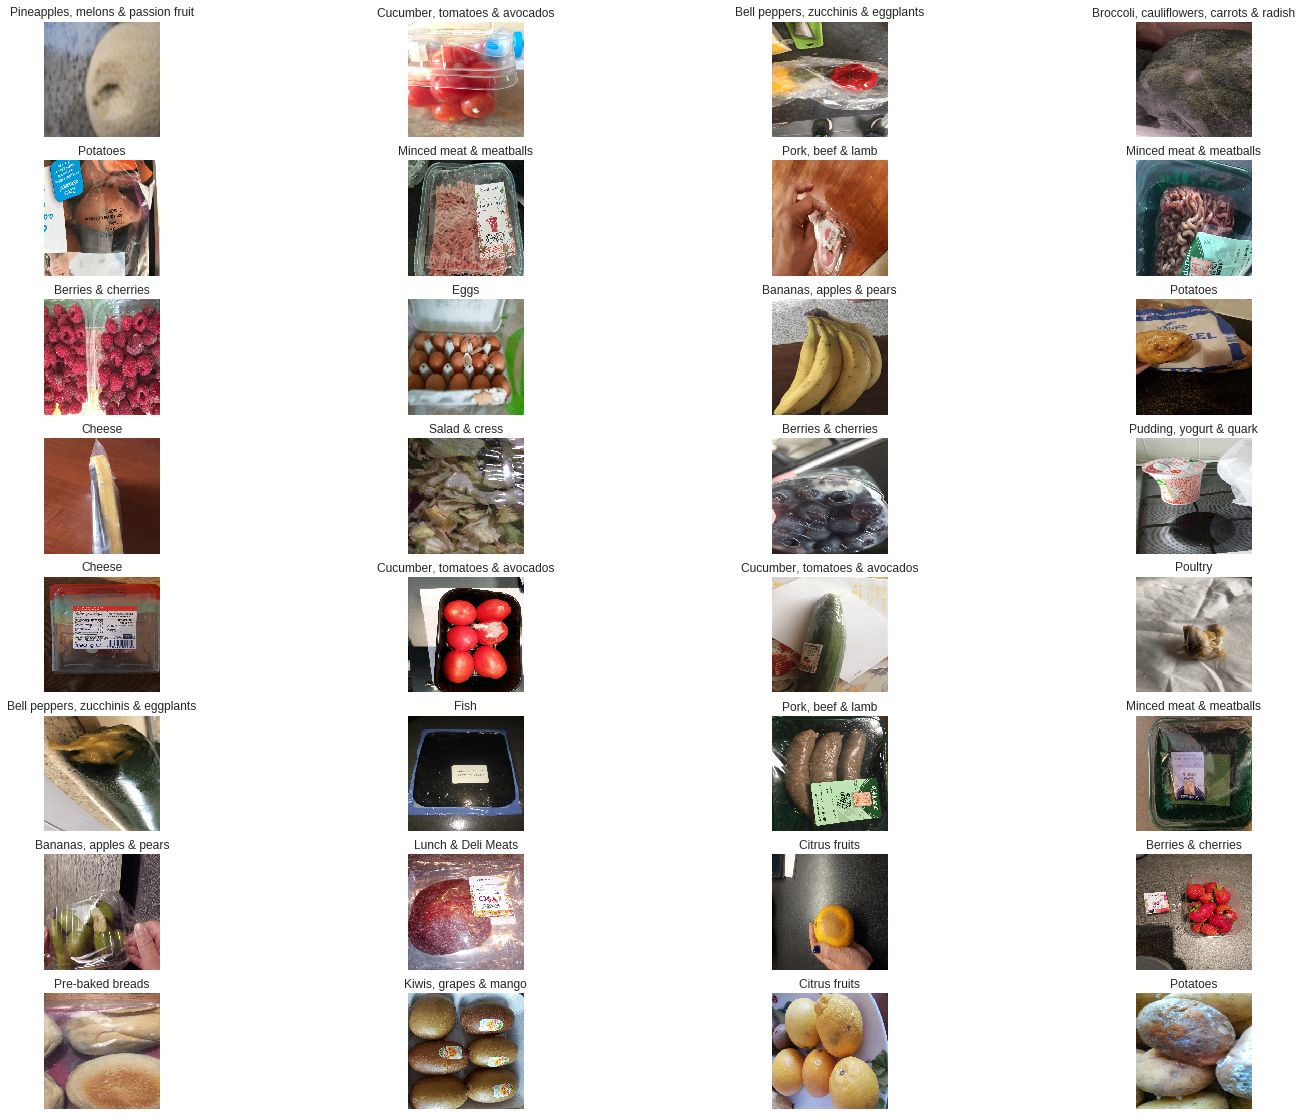

In [13]:
fig = plt.figure(figsize = (25,20))
for i in range(32):
  ax = fig.add_subplot(8,4, i+1, xticks = [], yticks = [])
  ax.imshow(X[i])
  ax.set_title(labels[np.argmax(y[i])])

## Building & Testing Model

In [0]:
# helper functions 
def train_model(model, epochs, name = "model", generator = True):
  early_stopping = EarlyStopping(patience=9)
  checkpointer = ModelCheckpoint(name + 'best.h5', monitor='val_acc', verbose=1, save_best_only=True)
  if generator:
    history = model.fit_generator(train_generator, epochs= epochs, 
                                  steps_per_epoch= step_epochs, 
                                  validation_steps=step_validation, 
                                  validation_data = valid_generator, 
                                  callbacks=[early_stopping, checkpointer])
  else:
    history = model.fit(x_train, y_train, epochs= epochs, batch_size = 32, 
                        validation_data= (x_test,y_test),
                       callbacks=[early_stopping, checkpointer])
  model.load_weights(name + 'best.h5')
  score = model.evaluate_generator(valid_generator, steps = step_validation)
  print('Accuracy of {}%'.format(score[1]*100))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Losses')
  plt.legend()
  plt.show()
  plt.plot(history.history['acc'], label='Training acc')
  plt.plot(history.history['val_acc'], label='Validation acc')
  plt.legend()
  plt.title('Accuracies')
  plt.show()

In [0]:
def train_model_fast(model, epochs, generator = True):
  if generator:
    history = model.fit_generator(train_generator, epochs= epochs, steps_per_epoch= step_epochs)
  else:
    history = model.fit(x_train, y_train, epochs= epochs, batch_size = 32)
  score = model.evaluate_generator(valid_generator, steps = step_validation)
  print('Accuracy of Validation was {}%'.format(score[1]*100))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['acc'], label='Training acc')
  plt.title('Results')
  plt.legend()
  plt.show()

In [0]:
# Building simple model
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))
model.summary()

In [0]:
train_model(model, 10)

In [0]:
# Building some complex models
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', input_shape = (224,224,3), activation = 'relu'))
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation = 'softmax'))
model.summary()

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop' , metrics = ['accuracy'])

In [0]:
train_model(model, 5)

## Transfer Learning

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 

## Summary of Pre-Trained Model

In [0]:
# helper function to visualize models 
def show_model(name, weight = 'imagenet', pool = 'avg'):
  
  if name == 'resnet':
    model = ResNet50(include_top=False, weights= weight, pooling= pool)
  if name == 'xception':
    model = Xception(include_top=False, weights= weight, pooling= pool)
  elif name == 'mobilenet':
    model = MobileNetV2(include_top=False, weights= weight, pooling= pool)
  elif name == 'nasnet':
    model = NASNetMobile(include_top=False, weights= weight, pooling= pool)
  elif name == 'nasnet_large':
    model = NASNetLarge(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  elif name == 'densenet121':
    
    model = DenseNet121(include_top=False, weights= weight, pooling= pool)
    for layer in model.layers[:-115]:
        layer.trainable = False
  elif name == 'densenet169':
    model = DenseNet169(include_top=False, weights= weight, pooling= pool)
  elif name == 'densenet201':
    model = DenseNet201(include_top=False, weights= weight, pooling= pool)
  elif name == 'vgg16':
    model = VGG16(include_top=False, weights= weight, pooling= pool)
  elif name == 'vgg19':
    model = VGG19(include_top=False, weights= weight, pooling= pool)
  elif name == 'inception_v3':
    model = InceptionV3(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  elif name == 'inception_resnet_v3':
    model = InceptionResNetV2(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  
  for layer in model.layers:
      
      print("{}, {}".format(layer, layer.trainable))
  model.summary()

## Training of Model

In [0]:
# helper method to freeze a model
def freeze_model(model, freeze):
    if freeze:
      for layer in model.layers:
          layer.trainable = False
    return model

In [0]:
# helper function to creat models 
def make_model(name, weight = 'imagenet', freeze = False, pool = 'avg'):
  model = Sequential()
  if name == 'resnet':      
    model.add(freeze_model(ResNet50(include_top=False, weights= weight, pooling= pool), freeze))
  if name == 'xception':
    model.add(freeze_model(Xception(include_top=False, weights= weight, pooling= pool), freeze))
  elif name == 'mobilenet':
    model.add(freeze_model(MobileNetV2(include_top=False, weights= weight, pooling= pool), freeze))
  elif name == 'densenet121':
    dense = DenseNet121(include_top=False, weights= weight, pooling= pool)
    model.add(freeze_model(dense, freeze))
  elif name == 'densenet169':
    model.add(freeze_model(DenseNet169(include_top=False, weights= weight, pooling= pool), freeze))
  elif name == 'densenet201':
    model.add(freeze_model(DenseNet201(include_top=False, weights= weight, pooling= pool), freeze))
  elif name == 'vgg16':
    vgg_conv = VGG16(include_top=False, weights= weight, pooling= pool)
    model.add(freeze_model(vgg_conv, freeze))
  elif name == 'vgg19':
    model.add(freeze_model(VGG19(include_top=False, weights= weight, pooling= pool), freeze))
  elif name == 'inception_v3':
    incpetion = InceptionV3(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
    model.add(freeze_model(incpetion, freeze))
  elif name == 'inception_resnet_v3':
    model.add(freeze_model(InceptionResNetV2(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool), freeze))
  elif name == 'nasnet':
    model.add(freeze_model(NASNetMobile(include_top=False, weights= weight, pooling= pool), freeze))
  elif name == 'nasnet_large':
    model.add(freeze_model(NASNetLarge(include_top=False, weights= weight, input_shape=(224,224,3), pooling = pool), freeze))
  
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(25, activation = 'softmax'))
  model.summary()
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
  
  return model   

## Exporting Results

In [0]:
files = glob.glob(path_to_folder + 'test/*')

In [0]:
results = []
i = 0
for file in files:
    print(i)
    i+=1
    img = cv2.imread(file,1)
    img = cv2.resize(img, (224, 224))
    img = img/255
    result = model_incption_resnet.predict([[img]])
    label = labels[np.argmax(result)]
    filename = os.path.basename(file)
    results.append([filename, label])

In [0]:
headers = ['file', 'label']
df = pd.DataFrame(results, columns=headers)

In [0]:
df = df.sort_values(['file'])

In [65]:
df.head()

,file,label
503,7263.jpeg,"Bell peppers, zucchinis & eggplants"
520,7264.jpeg,Eggs
571,7265.jpeg,"Broccoli, cauliflowers, carrots & radish"
332,7266.png,"Cucumber, tomatoes & avocados"
513,7267.jpeg,"Onions, leek, garlic & beets"


In [0]:
df.to_csv("incption_resnet_avg_30epoch_60_.tsv", sep ='\t', index = False)

In [0]:
model_incption.save_weights(path_to_folder + 'pinic_incption_resnet_avg_30epoch_60.h5')